In [1]:
import pandas as pd
import numpy as np
from cmdstanpy import CmdStanModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.12/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Wczytaj dane z pliku CSV
df = pd.read_csv('diabetes_pt1.csv', sep=';')
df_test = pd.read_csv('diabetes_pt2.csv', sep=';')

In [3]:
# Przygotuj dane do użycia w STAN
stan_data = {
    'N': len(df),
    'K': len(df.columns) - 1,
    'X': df.drop('Outcome', axis=1).values,
    'y': df['Outcome'].values
}

test_data = {
    'N': len(df_test),
    'K': len(df_test.columns) - 1,
    'X': df_test.drop('Outcome', axis=1).values,
    'y': df_test['Outcome'].values
}


In [4]:

# Kompilacja modelu
sm = CmdStanModel(stan_file='code.stan')

# Dopasowanie modelu
fit = sm.sample(data=stan_data, iter_sampling=2000, chains=4, iter_warmup=1000, seed=101)

# Pobieranie próbek beta
beta_0_samples = fit.stan_variable('beta_0')
beta_1_samples = fit.stan_variable('beta_1')

# Obliczanie średnich wartości beta
mean_beta_0 = np.mean(beta_0_samples, axis=0)
mean_beta_1 = np.mean(beta_1_samples, axis=0)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |▋         | 00:00 Iteration:    1 / 3000 [  0%]  (Warmup)







chain 1 |▉         | 00:02 Iteration:  100 / 3000 [  3%]  (Warmup)













chain 1 |█▎        | 00:03 Iteration:  200 / 3000 [  6%]  (Warmup)


chain 1 |█▌        | 00:04 Iteration:  300 / 3000 [ 10%]  (Warmup)




chain 1 |█▉        | 00:04 Iteration:  400 / 3000 [ 13%]  (Warmup)


chain 1 |██▏       | 00:04 Iteration:  500 / 3000 [ 16%]  (Warmup)


chain 1 |██▌       | 00:04 Iteration:  600 / 3000 [ 20%]  (Warmup)
chain 1 |██▊       | 00:05 Iteration:  700 / 3000 [ 23%]  (Warmup)

chain 1 |███▏      | 00:05 Iteration:  800 / 3000 [ 26%]  (Warmup)


chain 1 |███▍      | 00:05 Iteration:  900 / 3000 [ 30%]  (Warmup)


chain 1 |████      | 00:05 Iteration: 1001 / 3000 [ 33%]  (Sampling)


chain 1 |████▍     | 00:05 Iteration: 1100 / 3000 [ 36%]  (Sampling)



chain 1 |████▋     | 


INFO:cmdstanpy:CmdStan done processing.


In [5]:
# Prawdopodobieństwo klasy 1 dla każdej obserwacji
logits = np.dot(test_data['X'], (mean_beta_1 - mean_beta_0))
probs = 1 / (1 + np.exp(-logits))

# Decyzje na podstawie progu 0.5
preds = probs > 0.5

In [6]:
# Prawdziwe wartości
true_labels = test_data['y']
# Oblicz metryki oceny modelu
accuracy = accuracy_score(true_labels, preds)
precision = precision_score(true_labels, preds, zero_division=0)
recall = recall_score(true_labels, preds, zero_division=0)
f1 = f1_score(true_labels, preds, zero_division=0)
conf_matrix = confusion_matrix(true_labels, preds)

In [7]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.31
Precision: 0.31
Recall: 1.0
F1 Score: 0.4732824427480916
Confusion Matrix:
[[ 0 69]
 [ 0 31]]


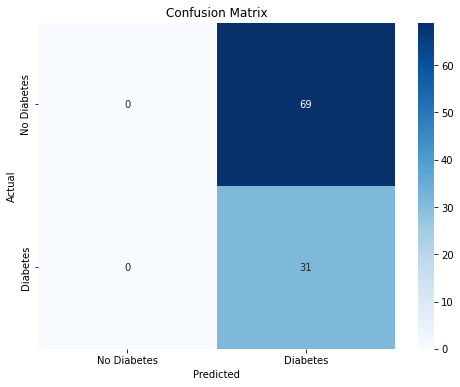

In [8]:
# Wizualizacja macierzy pomyłek jako mapa cieplna
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()